In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of attr._make failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 331, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 289, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/usr/local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 331, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 265, in update_function
    setattr(old, name, getattr(new, name))
ValueError: slots_setstate() requires a code object with 1 free vars, not 2

In [16]:
figname = '../paper/fig_methods'

In [17]:
%run 0_parameters.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
       
      
Using filename= ../data/2019-03-18
{'w': 28, 'minibatch_size': 100, 'train_batch_size': 600, 'test_batch_size': 1000, 'noise_batch_size': 1000, 'mean': 0.1307, 'std': 0.3081, 'N_pic': 128, 'offset_std': 30, 'offset_max': 35, 'noise': 0.7, 'contrast': 0.8, 'sf_0': 0.2, 'B_sf': 0.3, 'N_theta': 6, 'N_azimuth': 16, 'N_eccentricity': 10, 'N_phase': 2, 'rho': 1.41, 'bias_deconv': True, 'p_dropout': 0.5, 'dim1': 1000, 'dim2': 1000, 'lr': 0.0001, 'do_adam': True, 'bn1_bn_momentum': 0.0, 'bn2_bn_momentum': 0.0, 'momentum': 0.1, 'epochs': 10, 'num_processes': 1, 'no_cuda': True, 'log_interval': 100, 'verbose': 1, 'filename': '../data/2019-03-18', 'seed': 2019, 'N_cv': 2}
Overwriting train.py
The watermark extension is already loaded. To reload it, use:
  %r

# Definition of the input and the output 

## Representation of input image (retina)

In [18]:
from retina import Display
d = Display(args)

In [19]:
from retina import Retina
r = Retina(args)

In [20]:
data, label = next(iter(d.loader_test))
idx = 4
data_fullfield, i_offset, j_offset = d.draw(data[idx, 0, :, :].numpy())
data_retina = r.retina(data_fullfield)

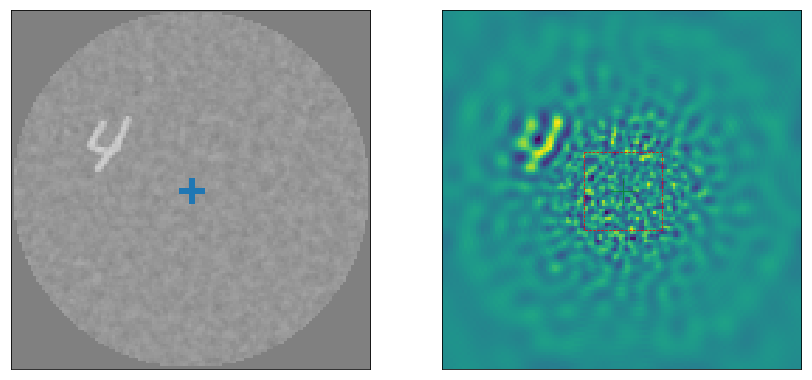

In [21]:
fig, axs = plt.subplots(1, 2, figsize = (figwidth, figwidth/2))
axs[0] = d.show(axs[0], data_fullfield)
axs[1] = r.show(axs[1], r.retina_invert(data_retina))

## Representation of output accuracy (colliculus)

In [22]:
path = "../data/MNIST_accuracy.npy"
if os.path.isfile(path):
    accuracy_map =  np.load(path)
    if args.verbose:
        print('Loading accuracy... min, max=', accuracy_map.min(), accuracy_map.max())
else:
    print('No accuracy data found.')

Loading accuracy... min, max= 0.0145 0.9852


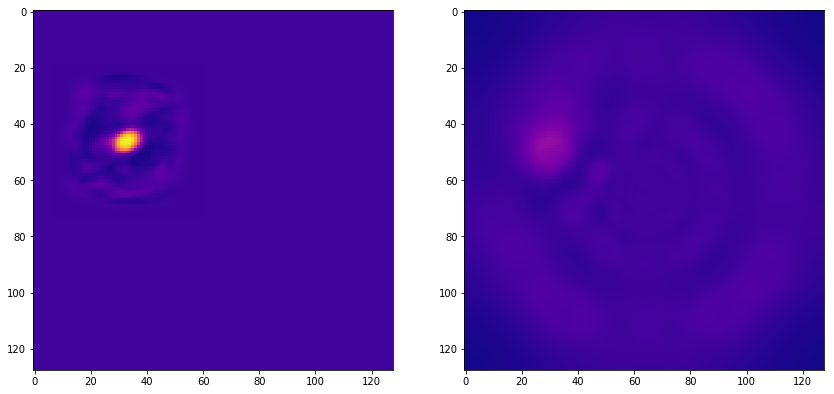

In [23]:
accuracy_colliculus, accuracy_fullfield_map = r.accuracy_fullfield(accuracy_map, i_offset, j_offset)

fig, axs = plt.subplots(1, 2, figsize = (figwidth, figwidth/2))
axs[0].imshow(accuracy_fullfield_map, vmin=0, vmax=1, cmap=plt.plasma())
axs[1].imshow(r.accuracy_invert(accuracy_colliculus), vmin=0, vmax=1, cmap=plt.plasma())


# Evaluating the accuracy of the classifier (What) wrt to spatial shifts

On commence par la fonction de base apprise de la librairie torch, cf https://raw.githubusercontent.com/pytorch/examples/master/mnist/main.py :

In [24]:
%whos

Variable                 Type        Data/Info
----------------------------------------------
Display                  type        <class 'retina.Display'>
Retina                   type        <class 'retina.Retina'>
WhatNet                  type        <class 'what.WhatNet'>
Where                    type        <class 'where.Where'>
WhereNet                 type        <class 'where.WhereNet'>
accuracy_colliculus      ndarray     160: 160 elems, type `float64`, 1280 bytes
accuracy_fullfield_map   ndarray     128x128: 16384 elems, type `float64`, 131072 bytes (128.0 kb)
accuracy_map             ndarray     55x55: 3025 elems, type `float64`, 24200 bytes
args                     EasyDict    {'w': 28, 'minibatch_size<...> 'seed': 2019, 'N_cv': 2}
axs                      ndarray     2: 2 elems, type `object`, 16 bytes
d                        Display     <retina.Display object at 0x14da6e198>
data                     Tensor      tensor([[[[-0.4242, -0.42<...>42, -0.4242, -0.4242]]]])
data

In [25]:
from what import WhatNet
model = WhatNet()


On apprend une matrice de poids qui est fixée dans la suite et que nous allons utiliser pour la classification

In [26]:
%ls -ltr ../data/MNIST_cnn.pt
#%rm -f ../data/MNIST_cnn.pt

-rw-r--r--  1 laurentperrinet  staff  1736289 Mar 14 12:31 ../data/MNIST_cnn.pt


In [27]:
model_path = "../data/MNIST_cnn.pt"

import os
import torch
if os.path.isfile(model_path):
    print('Loading')
    model = torch.load(model_path)
    #model.load_state_dict(torch.load(model_path))
else:
    print('Learning')
    import time
    t0 = time.time()
    %run what.py --epochs 10 --save-model
    print('Done in ', time.time() - t0, 'seconds')

Loading


## Using the learned classifier in a standalone class

Maintenant qu'on a appris les points qui permet une classification d'à peu près 98 % on va utiliser le modèle fead-forward pour faire la classification.

In [28]:
from retina import Display
d = Display(args)
data, label = next(iter(d.loader_test))

In [29]:
model = WhatNet()
model.load_state_dict(torch.load(model_path))
from what import test
accuracy = test(args, model, torch.device("cpu"), d.loader_test)
print('accuracy=', accuracy)

AttributeError: 'WhatNet' object has no attribute 'copy'

## shifting the input images


Je vais maintenant générer des données en utilisant les données originales de MNIST translatées :

In [ ]:
from torchvision import datasets, transforms
i_shift, j_shift = 12, 17
N_pix = 28

In [ ]:
from retina import Display
d = Display(args)
data, label = next(iter(d.loader_test))

In [ ]:
fig, ax = plt.subplots()
ax.imshow(data[0, 0, :, :].numpy())

In [ ]:
data = data.numpy()
data_translate = data.min() * np.ones((data.shape[0], 1, N_pix*3 - 2, N_pix*3 - 2))
print(data_translate.shape)
data_translate[:, :, (N_pix-i_shift):(2*N_pix-i_shift), (N_pix-j_shift):(2*N_pix-j_shift)] = data
fig, ax = plt.subplots()
ax.imshow(data_translate[0, 0, :, :])

In [ ]:
data_cropped = data_translate[:, :, (N_pix):(2*N_pix), (N_pix):(2*N_pix)]
fig, ax = plt.subplots()
ax.imshow(data_cropped[0, 0, :, :])

In [ ]:
np.arange(-N_pix+1, N_pix)

In [ ]:
def shift_data(data, i_shift, j_shift):
    N_pix = data.shape[-1]
    assert(N_pix == data.shape[-2])
    import numpy as np
    data_translate = data.min() * np.ones((data.shape[0], 1, N_pix*3 - 1, N_pix*3 - 1))
    data_translate[:, :, (N_pix+i_shift):(2*N_pix+i_shift), (N_pix+j_shift):(2*N_pix+j_shift)] = data
    data_cropped = data_translate[:, :, (N_pix):(2*N_pix), (N_pix):(2*N_pix)]
    return data_cropped

data_cropped = shift_data(data, i_shift = 12, j_shift = -12)
fig, ax = plt.subplots()
ax.imshow(data_cropped[0, 0, :, :])

## Using the learned classifier on the shifted data

On peut maintenant tester le classifieur sur les images Translatées en calculant la valeur de classification en  fonction de l'erreur de localisation

In [ ]:
def test_shift(test_loader, i_shift, j_shift, verbose=0):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data_cropped = shift_data(data, i_shift=i_shift, j_shift=j_shift)        
        data_cropped = torch.FloatTensor(data_cropped) #transforms.ToTensor()(data_cropped)
        data_cropped, target = Variable(data_cropped, volatile=True), Variable(target)
        output = model(data_cropped)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    if verbose: print('\nTest set: at ({}, {}), the  average loss is {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        i_shift, j_shift, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset)


path = "../data/MNIST_accuracy.npy"

import os
if os.path.isfile(path):
    print('Loading accuracy')
    accuracy = np.load(path)
else:
    print('Computing accuracy')
    import time
    t0 = time.time()
    accuracy = np.zeros((2*N_pix-1, 2*N_pix-1))
    from tqdm import tqdm
    N_step = 1

    with tqdm(total=(2*N_pix-1)**2/N_step**2) as pbar:
        for i_shift in np.arange(-N_pix+1, N_pix, N_step):
            for j_shift in np.arange(-N_pix+1, N_pix, N_step):
                accuracy[i_shift+N_pix-1, j_shift+N_pix-1] = test_shift(test_loader, i_shift, j_shift)
                pbar.update()
    np.save(path, accuracy)
    print('Done in ', time.time() - t0, 'seconds')
    
print('accuracy=', accuracy)    

J'avoue que c'est un peu bourrin de calculer la classification sur les 128 × 128 pixels pour 1000 batch multiplié par 10 type d'entrées.... Mais bon on doit faire ça seulement une fois :-) (et sur CPU une classif = environ 300µs ...)

In [ ]:
fig, ax = plt.subplots(figsize=(13, 10.725))
cmap = ax.pcolor(np.arange(-N_pix+1, N_pix+1), np.arange(-N_pix+1, N_pix+1), accuracy, cmap=plt.plasma())
ax.axis('equal')
fig.colorbar(cmap)

Cette fonction de performance du classifieur  est calculée indépendamment de la forme spécifique du chiffre entre 0 et 9. Elle donne donc la carte de performance qu'on attend Au niveau de la classification/ On va pouvoir maintenant l'utiliser ceomm label pour apprendre de façon supervisée la correspondance entre la carte log-polaire obtenue depuis l'image brute et cette carte de performance.

# Retinotopic mapping

## Orientation invariant power encoding (colliculus??)

In [ ]:
from retina import Retina
r = Retina(args)

In [ ]:
print('r.colliculus.shape=', r.colliculus.shape)

In [ ]:
print('r.colliculus_vector.shape=', r.colliculus_vector.shape)

In [ ]:
print('r.colliculus_inverse.shape=', r.colliculus_inverse.shape)

In [ ]:
energy = (r.retina_transform**2).sum(axis=(0,3)) 
energy /= energy.sum(axis=-1)[:, :, None]
energy_vector = energy.reshape((args.N_azimuth*args.N_eccentricity, args.N_pic**2))
energy_plus = np.linalg.pinv(energy_vector)
FIG_WIDTH = 5 

fig, ax = plt.subplots(figsize=(figwidth, figwidth))
for i_orient in range(args.N_azimuth):
    for i_scale in range(args.N_eccentricity):
        env = np.sqrt(energy[i_orient, i_scale, :]**2.5).reshape((args.N_pic, args.N_pic))
        ax.contour(energy[i_orient, i_scale, :].reshape((args.N_pic, args.N_pic)), levels=[env.max()/2], lw=1,
                  colors=[plt.cm.rainbow(i_scale * 1.5/args.N_azimuth)])
fig.suptitle('Tiling of visual space using energy', y=1.02)
ax.set_xlabel(r'$Y$')
ax.set_ylabel(r'$X$')
ax.axis('equal')
plt.tight_layout()

# summary


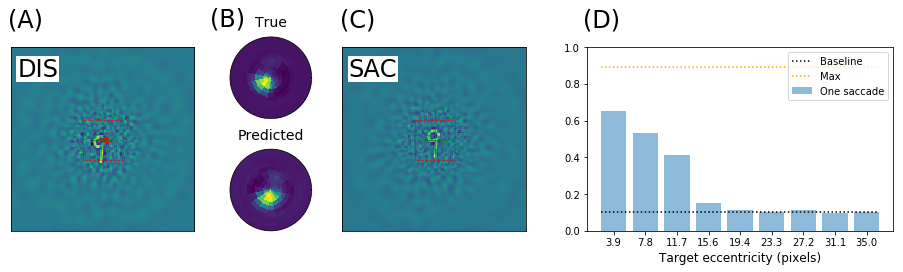

In [14]:
fig = plt.figure(figsize = (figwidth, figwidth/2.5))#1.618))
ax_A = plt.subplot(1, 3, 1) 
data_retina = where.retina.retina(full[idx]['data_fullfield'])
ax_A = where.retina.show(ax_A, where.retina.retina_invert(data_retina))
    
ax_B = plt.subplot(1, 3, 2, projection='polar', autoscale_on=False)
ax_B.pcolor(where.retina.theta, where.retina.log_r, accuracy_colliculus[idx, :].numpy().reshape((args.N_azimuth, args.N_eccentricity)))
ax_B.grid('off')
plt.title('True', fontsize = 14)
ax_B.set_yticklabels([])
ax_B.set_xticklabels([])

ax_Bb = plt.subplot(2, 4, 6, projection='polar')
ax_Bb.pcolor(where.retina.theta, where.retina.log_r, pred_accuracy_colliculus[idx, :].reshape((args.N_azimuth, args.N_eccentricity)))
ax_Bb.set_title('Predicted', fontsize = 14)
ax_Bb.set_yticklabels([])
ax_Bb.set_xticklabels([])


ax_C = plt.subplot(1, 3, 3)
data_fullfield = where.display.place_object(data[idx, 0, :, :].numpy(), 0, 0)
input_vector  =  where.retina.retina(data_fullfield)
ax_C = where.retina.show(ax_C, where.retina.retina_invert(input_vector))
i_pred, j_pred = where.index_prediction(pred_accuracy_colliculus[idx, :])
ax_A.arrow(64.5, 64.5, -i_pred, -j_pred, width=.3, color='r', head_width=4., length_includes_head=True, edgecolor='k')

offset = -.015
for ax, text, x_offset, y_offset in [[ax_A, 'A', offset, 1.15], [ax_B, 'B', -.25, 1.225], [ax_C, 'C', offset, 1.15]]:
    ax.text(x_offset, y_offset, '(' + text + ')', fontsize=24,
              bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
              ha='left', va='center', transform=ax.transAxes) 

# pos : [left, bottom, width, height] =    The new position of the in `.Figure` coordinates.    
plt.tight_layout()
ax_A.set_position([0.025, 0.1, .3, .45])
ax_B.set_position( [0.24, 0.375, .2, 0.2])
ax_Bb.set_position([0.24, 0.1, .2, 0.2])
ax_C.set_position([0.35, .1, .3, .45])

fig.savefig(figname + '.pdf', bbox_inches='tight', pad_inches=0.1)

# post-processing

In [15]:
!convert  -density {dpi_export} {figname}.pdf {figname}.jpg
!convert  -density {dpi_export} {figname}.pdf {figname}.png
#!convert  -density {dpi_export} -resize 5400  -units pixelsperinch -flatten  -compress lzw  -depth 8 {fname}.pdf {fname}.tiff

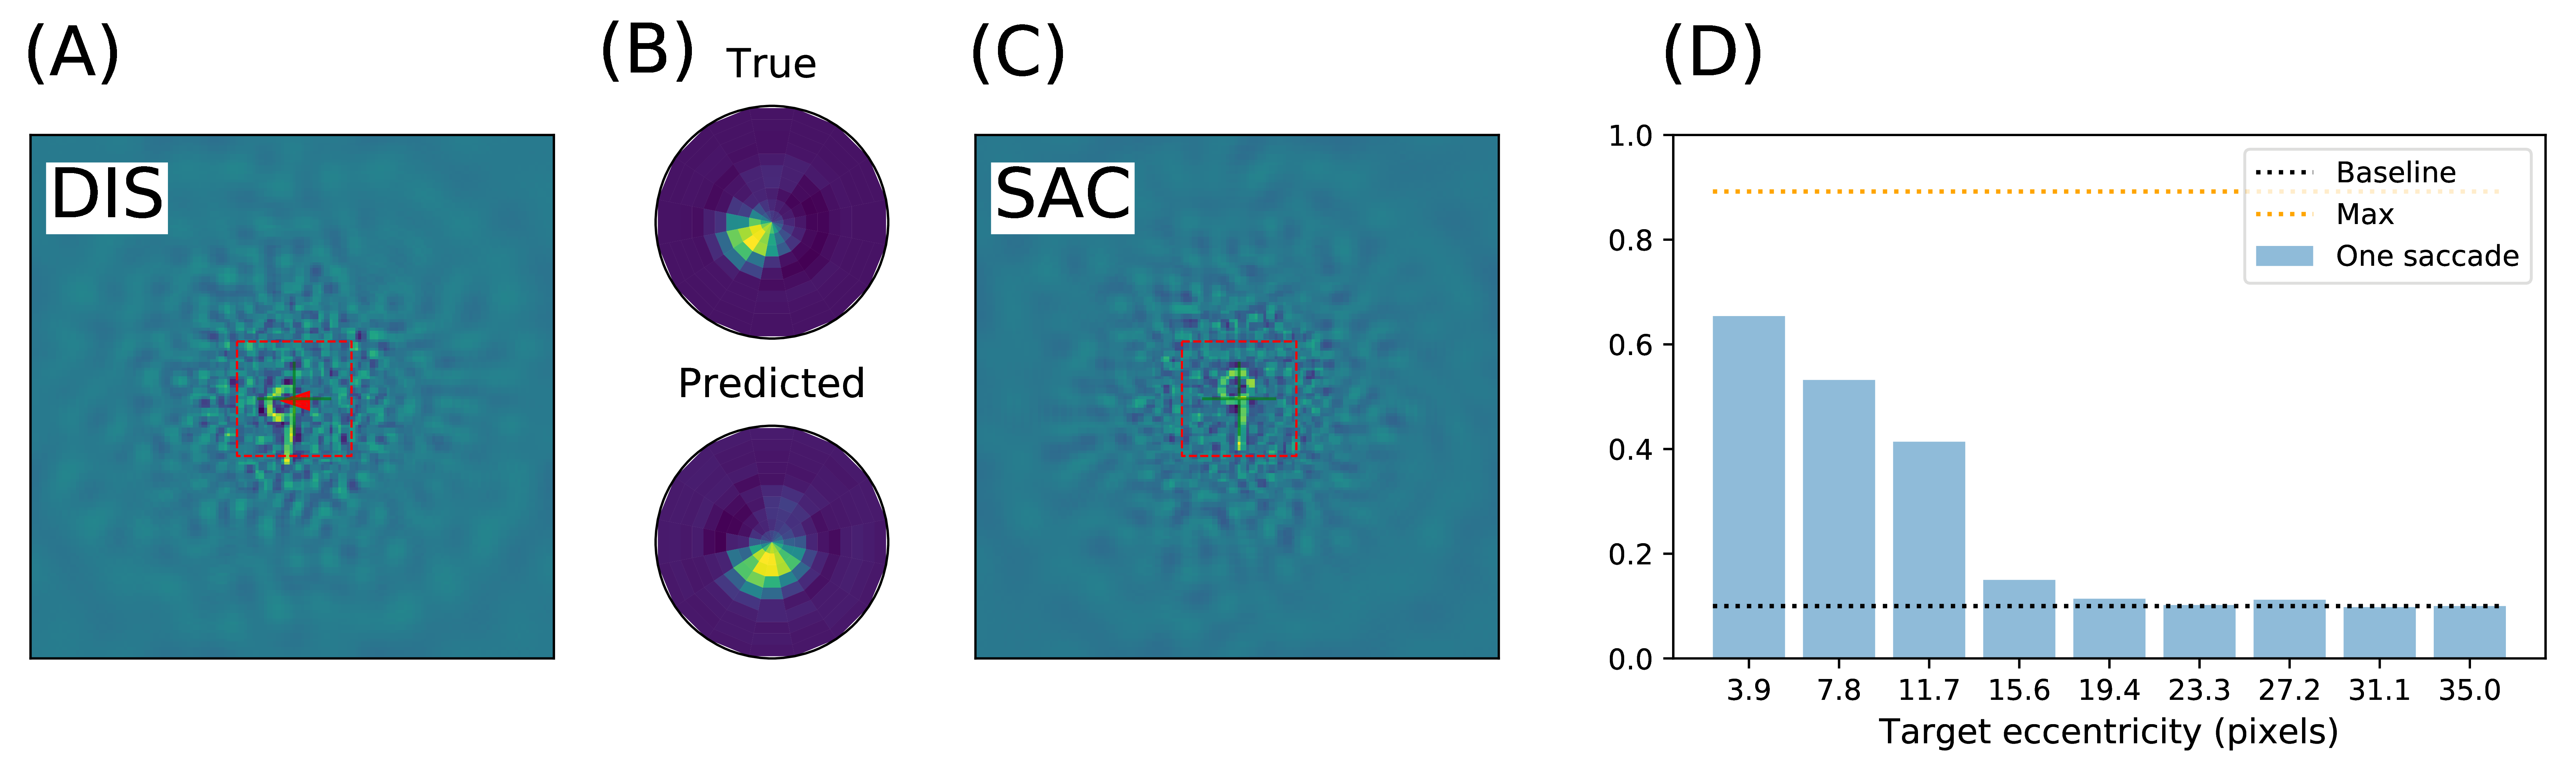

In [16]:
from IPython.display import Image
Image('{figname}.png'.format(figname=figname))

In [17]:
!ls  -l {figname}*

-rw-r--r--  1 laurentperrinet  staff  1068639 Mar 15 17:08 ../paper/fig_result.jpg
-rw-r--r--@ 1 laurentperrinet  staff    65214 Mar 15 17:08 ../paper/fig_result.pdf
-rw-r--r--  1 laurentperrinet  staff   399656 Mar 15 17:08 ../paper/fig_result.png
